# `CNModel` Degeneracies

Trey V. Wenger (c) December 2024

The optical depth is given by

$\tau_\nu = \frac{c^2}{8\pi\nu^2}(e^{h\nu/(kT_{\rm ex})} - 1)N_u A_{ul} \phi_\nu$

and the equation of radiative transfer is

$T_B(\nu) = T_{\rm ex} (1 - e^{-\tau_\nu})$.

At $\sim115\,{\rm GHz}$, the term $h\nu/(kT_{\rm ex})$ is $\ll 1$ for $T_{\rm ex} > 30\,{\rm K}$ and thus $\tau \propto N_u A_{ul} \phi_\nu/T_{\rm ex}$. In the optically thin limit, then $T_B(\nu) = T_{\rm ex}\tau \propto N_u A_{ul} \phi_\nu$ and we lose the ability to constrain either the excitation temperature or the optical depth from the relative intensities of the spectral lines. All we can constrain is the column density (and line shape).

In the optically thick limit, $T_B(\nu) = T_{\rm ex}$ and we lose the ability to constrain the optical depth.

If we assume LTE and have the ability to independently estimate the kinetic temperature (and thus the excitation temperature) from the spectral line width (i.e., when non-thermal broadening is not important and when the data have sufficient spectral resolution), then it is possible to constrain the excitation temperature.

Otherwise (if non-LTE, or if non-thermal broadening is important, or if the data do not have sufficient spectral resolution to resolve the thermal line widths), the model will be degenerate except for small excitation temperatures and/or large optical depths.

For example, note the degeneracies in the `CNModel` tutorial posterior distributions (see below).

![cn_posterior_2](cn_model_posterior_2.png)

This cloud had a large excitation temperature and small optical depth. Thus we are not able to place particularly good constraints on either.

![cn_posterior_0](cn_model_posterior_0.png)

This cloud, on the other hand, had a large optical depth and small excitation temperature, thus we were able to break the degeneracy and constrain both.

Having degeneracies in the model is not necessarily a problem *statistically*, but it could be a problem *numerically* (i.e., for MCMC). For the unconstrained cloud above, the optical depth is an only an upper limit and the kinetic (excitation) temperature is basically unconstrained (posterior is similar to prior). The column density and kinetic (excitation) temperature are correlated, meaning that our assumption about the kinetic (excitation) temperature is properly reflected in the marginal posterior distribution of the column density -- the uncertainty in the temperature is propogated into an uncertainty in the column density with a full physical treatment rather than relying on the first-order approximations described above.

Degeneracies can cause problems with MCMC since they create tight curvatures in the posterior topology. You should ideally use informative priors and see what happens, as in the `CNModel` tutorial notebook. Note, however, the divergences during sampling. These are a sign of sampling issues with degenerate models.

If necessary, we can overcome the model degeneracies by *assuming* a kinetic temperature (and also excitation temperature in LTE), as demonstrated below. This is equivalent to conditioning the posterior distribution on the fixed parameter. It's like taking a slice through the posterior distributions. Thus the marginal, conditional probability distributions might not reflect how the realistic uncertainties in the fixed parameter (i.e., excitation temperature) propogate into the other inferred parameters (i.e., column density).

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## Simulate data

Transition 113144.19 is constraining upper state 4 from lower state 0
Transition 113191.325 is constraining upper state 3 from lower state 0
Transition 113490.985 is constraining upper state 0 from lower state 0
Transition 113508.934 is constraining upper state 1 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 4
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]]

tau_peak

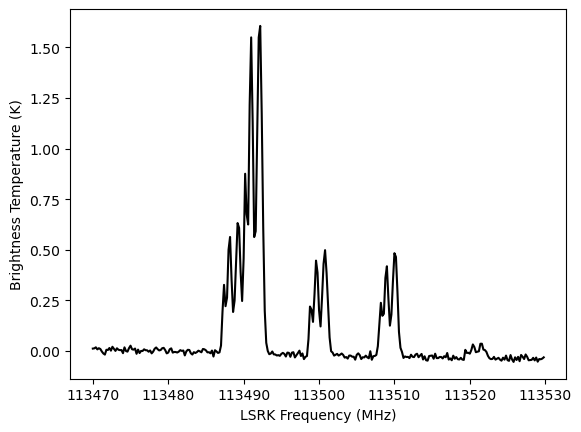

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(brightness_data)
observation._brightness_scale = observation.noise
dummy_data = {"observation": observation}

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [12.5, 12.2, 11.8],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [-2.0, -5.0, 8.0],
}
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")
Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau_peak = model.model.tau_peak.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau_peak:")
print(tau_peak)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

## Model Definition

Here we fix the kinetic temperature and excitation temperature (since we assume LTE).

In [11]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(sim_brightness)
observation._brightness_scale = observation.noise
data = {"observation": observation}

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 0.1], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = 1.5, # assume a kinetic temperature = excitation temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 4 from lower state 0
Transition 113191.325 is constraining upper state 3 from lower state 0
Transition 113490.985 is constraining upper state 0 from lower state 0
Transition 113508.934 is constraining upper state 1 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 4
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


Sampling: [baseline_observation_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, observation, velocity_norm]


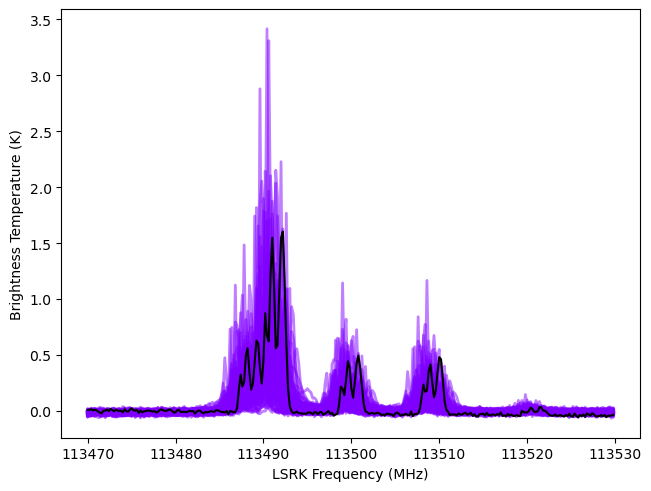

In [12]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [24]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.1, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.03, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,192.9


Output()

Runtime: 0.38 minutes


In [25]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.1, "abs_tolerance": 0.1, "learning_rate": 0.03}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,192.9
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


Adding log-likelihood to trace


Output()

There were 6 divergences in converged chains.
Runtime: 1.31 minutes


In [26]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [observation]


Output()

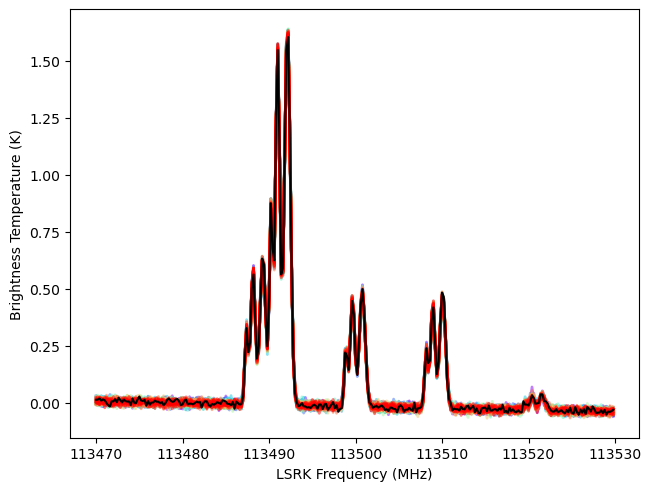

In [27]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

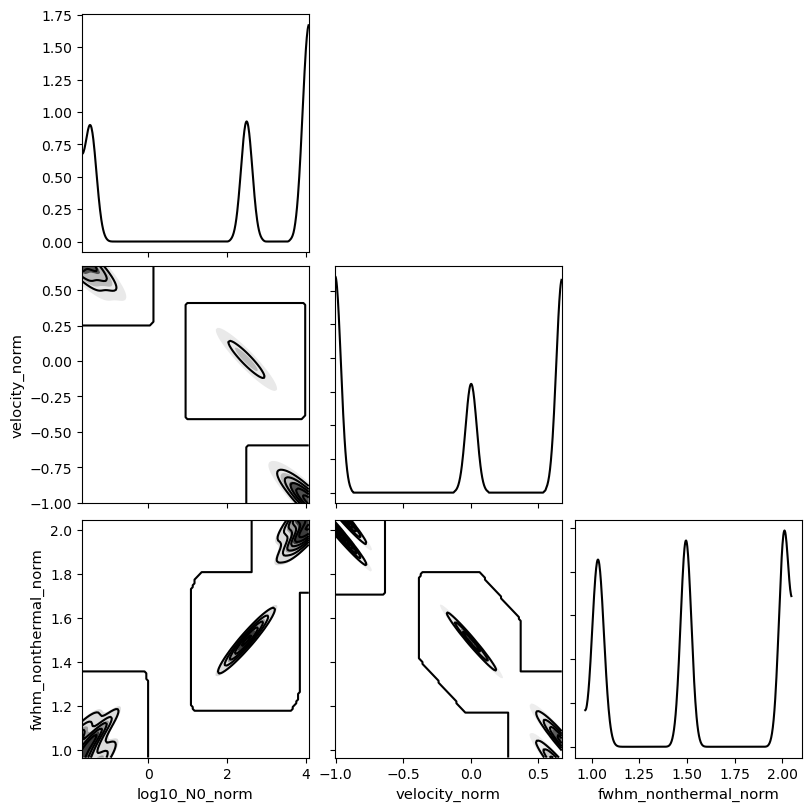

In [28]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

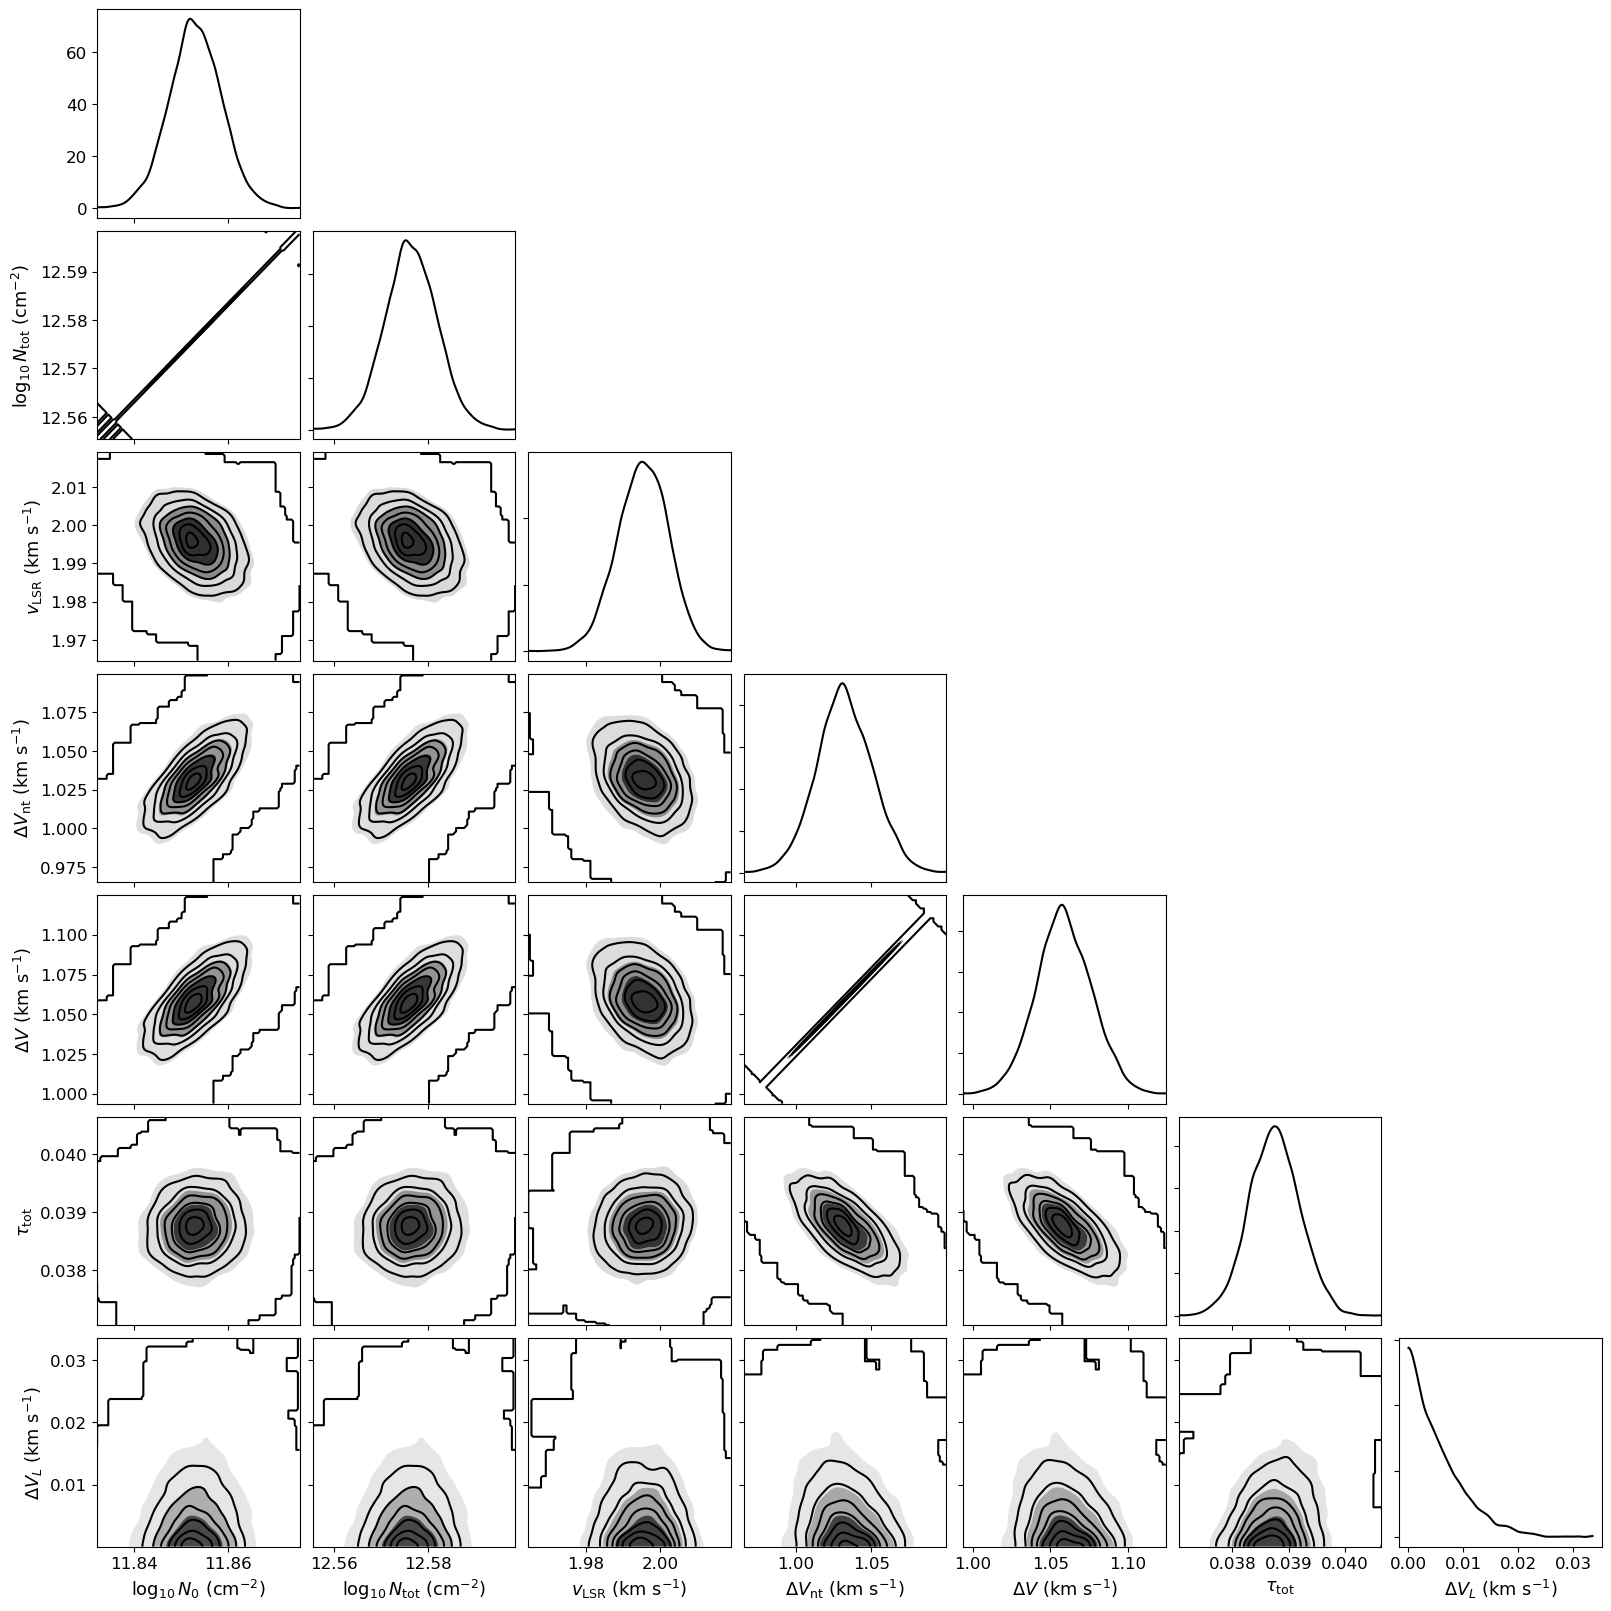

In [29]:
# ignore transition and state dependent parameters, as well as fixed parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
    and param not in ["log10_Tkin", "fwhm_thermal", "log10_Tex_mean"]
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names=var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

This model has no degeneracies, but we are also unable to constrain the excitation temperature (because it is assumed) or optical depth (because of the bias introduced by the kinetic temperature = excitation temperature assumption). Note how the *conditioned* column density posterior distribution is much more precise. This is a bias introduced by our assumption.